#imports

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler 

  # config

In [39]:
batch_size = 128
val_rate = 0.1
num_workers = 2
device = torch.device('cuda')
epochs = 30

# Downloading and Creating Train and Test Sets

In [40]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root = 'data',
                            train=True,
                            download=True,
                            transform=transform)

test_data = datasets.MNIST(root = 'data',
                           train=False,
                           download=True,
                           transform=transform)

# DataLoader

In [41]:
num_train = int(np.floor(len(train_data) * (1 - val_rate)))
num_val = len(train_data) - num_train  
idxs = list(range(0, num_train + num_val))
train_idx, val_idx = idxs[0: num_train - 1],idxs[num_train: num_train + num_val - 1]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=val_sampler,
                                           num_workers=num_workers)  

test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=batch_size,
                                             num_workers=num_workers)            

# Defining Network Class

In [42]:
class Net(nn.Module):
  def __init__(self, hidden_1=512, hidden_2=512):
    super().__init__()
    self.z1 = nn.Linear(28 * 28, hidden_1)
    self.a1 = nn.ReLU()
    self.z2 = nn.Linear(hidden_1, hidden_2)
    self.a2 = nn.ReLU()
    self.z3 = nn.Linear(hidden_2, 10)
  
  def forward(self, x):
    x = x.view(-1, 28*28)
    x = self.z3(self.a2(self.z2(self.a1(self.z1(x)))))
    return x


# Instantiating the Model

In [95]:
model = Net()
model.to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_function = nn.CrossEntropyLoss()

# Training

In [96]:
val_loss_min = np.Inf
val_loss_list = []
train_loss_list = []
for epoch in range(20):
  train_loss = 0
  for iteration, (data, label) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model.forward(data.to(device))
    loss = loss_function(output, label.to(device))
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * batch_size

    if(iteration % 500 == 0):
      val_loss = 0
      for (data, label) in val_loader:
        output = model.forward(data.to(device))
        loss = loss_function(output, label.to(device))
        val_loss += loss.item() * batch_size
      val_loss /= len(val_loader.sampler)
      val_loss_list.append(val_loss)
      if (val_loss < val_loss_min):
        print(f'validation loss decresead from {val_loss_min} to {val_loss}')
        val_loss_min = val_loss
        torch.save(model.state_dict(),'model.pt')
  print(f'epoch:{epoch} training loss {train_loss/len(train_loader.sampler)}')
  train_loss_list.append(train_loss)

validation loss decresead from inf to 2.3089495272731
epoch:0 training loss 0.6806522700986999
validation loss decresead from 2.3089495272731 to 0.2628713656433584
epoch:1 training loss 0.2704024243618387
validation loss decresead from 0.2628713656433584 to 0.18850423701903604
epoch:2 training loss 0.2002760105418811
validation loss decresead from 0.18850423701903604 to 0.1425868979611582
epoch:3 training loss 0.15770648545222263
validation loss decresead from 0.1425868979611582 to 0.1306017926383523
epoch:4 training loss 0.1280654549132886
validation loss decresead from 0.1306017926383523 to 0.11044714088776962
epoch:5 training loss 0.1057520332167587
validation loss decresead from 0.11044714088776962 to 0.09289308137984291
epoch:6 training loss 0.08934030553323631
validation loss decresead from 0.09289308137984291 to 0.0865908924550449
epoch:7 training loss 0.07644466459160591
validation loss decresead from 0.0865908924550449 to 0.08198178980942268
epoch:8 training loss 0.06664870049

# checking accuracy on test set

In [108]:
model = Net()
model.load_state_dict(torch.load('model.pt'))
loss = 0
true_predict = 0
for (data, label) in test_loader:
  output = model(data)
  pred = torch.argmax(output, dim = 1)
  true_predict += torch.sum(pred == label).item()
accuracy = true_predict / len(test_loader.sampler)
print('Accuracy : {:.2%}'.format(accuracy))

Accuracy : 97.89%


# We have achieved 97.89% accuracy in our model

# 16 sample predictions frome test set

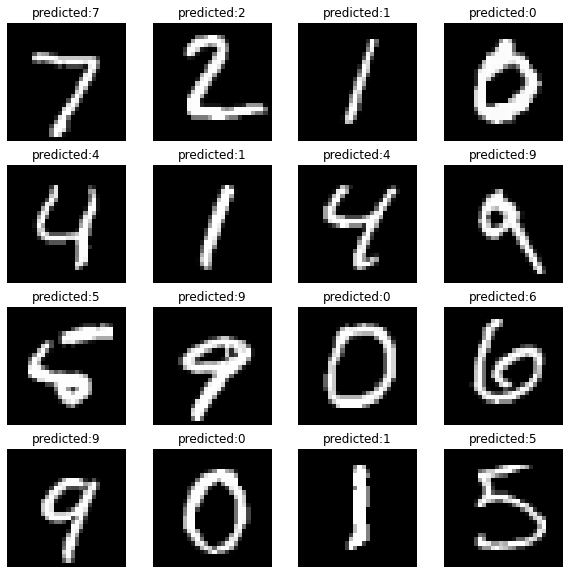

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

#img = mpimg.imread('night.jpg')
#plt.imshow(img,cmap='gray')
#img = torch.tensor(img, dtype=torch.float)
rows = 4
columns = 4
plt.rcParams['figure.figsize'] = (10.0, 10.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

for i in range(rows*columns):
    img = test_loader.dataset.data[i].float()
    output = torch.argmax(model(img)) 
    plt.subplot(rows, columns, i + 1)
    plt.title(f"predicted:{output}")
    plt.axis('off')
    plt.imshow(img)
plt.show()

